In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from fancyimpute import KNN, IterativeImputer 

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

train_path = "res/CongressionalVotingID.shuf.train.csv"
test_path = "res/CongressionalVotingID.shuf.test.csv"
result_folder = "results/"

test_set_ratio = 0.1 

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train = df_train.replace({'y':True, 'n':False, 'unknown':np.nan})
df_test = df_test.replace({'y':True, 'n':False, 'unknown':np.nan})

df_train.head(10)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,134,republican,False,False,False,True,True,True,False,False,False,True,False,True,True,True,False,True
1,224,republican,False,False,False,True,True,False,False,False,False,False,False,True,True,True,False,True
2,32,democrat,True,True,True,False,False,False,True,True,True,False,True,False,False,False,True,NaN
3,171,democrat,True,False,True,False,False,False,NaN,True,True,NaN,False,False,False,False,True,NaN
4,333,democrat,True,False,True,False,False,False,True,True,True,False,True,False,False,False,True,NaN
5,148,democrat,False,False,False,False,False,False,True,True,True,True,False,True,True,True,True,True
6,83,republican,False,False,False,True,True,True,False,False,False,True,False,True,True,True,False,True
7,24,democrat,True,True,True,False,False,False,True,True,True,False,False,False,False,False,True,True
8,281,democrat,False,False,True,False,False,False,True,True,True,True,False,False,False,True,False,True
9,416,democrat,False,True,True,False,False,True,True,True,NaN,True,False,False,False,False,False,True


### Initialize Training data

In [12]:
df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

# impute nans
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp.fit(df_vars)
#df_vars = imp.transform(df_vars)
#df_test = imp.transform(df_test)

#df_vars = IterativeImputer().fit_transform(df_vars)
#df_test = IterativeImputer().fit_transform(df_test)

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=.2, random_state=3124132)
#clf = RandomForestClassifier(n_estimators=100, max_features=1)
#clf = SVC(kernel='linear', random_state=123093234)
#clf = GaussianNB()

### Simple cross validation for well-founded results

In [15]:
scores = cross_validate(clf, df_vars, df_class, cv=10)
scores['test_score']

array([0.91304348, 0.95454545, 0.90909091, 1.        , 0.95454545,
       0.95454545, 0.95454545, 0.9047619 , 1.        , 1.        ])

### Model fitting and sample testing

In [16]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.9318181818181818

### Final prediction

In [17]:
df_res = pd.DataFrame()
df_res['ID'] = df_test[:,0].astype(int)
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,368,democrat
1,15,republican
2,94,democrat
3,107,republican
4,285,democrat
5,53,democrat
6,138,democrat
7,265,democrat
8,419,democrat
9,226,republican


### Export

In [11]:
export_file_name = result_folder + "svm_knn_imputed.csv"
df_res.to_csv(export_file_name, index=False)

### Easy comparison

In [4]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

df_vars = IterativeImputer().fit_transform(df_vars)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring='accuracy', return_train_score=True)
        cl_scores[name] = scores
        print(name,"-- Training Set --", "Mean", scores['train_score'].mean(), "-- Min", scores['train_score'].min(), "-- Max", scores['train_score'].max())
        print(name,"-- Test Set --", "Mean", scores['test_score'].mean(), "-- Min", scores['test_score'].min(), "-- Max", scores['test_score'].max())
    except:
        print("Classification failed for", name)
        traceback.print_exc()

Nearest Centroid -- Training Set -- Mean 0.5055967455314809 -- Min 0.4897959183673469 -- Max 0.5204081632653061
Nearest Centroid -- Test Set -- Mean 0.4943628834933184 -- Min 0.38095238095238093 -- Max 0.6363636363636364
Linear SVM -- Training Set -- Mean 0.9842043658541121 -- Min 0.9744897959183674 -- Max 0.9948717948717949
Linear SVM -- Test Set -- Mean 0.9590532655750048 -- Min 0.9090909090909091 -- Max 1.0
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.9495482778091473 -- Min 0.8636363636363636 -- Max 1.0
Naive Bayes -- Training Set -- Mean 0.9587146682179315 -- Min 0.949238578680203 -- Max 0.9695431472081218
Naive Bayes -- Test Set -- Mean 0.9545078110295503 -- Min 0.9047619047619048 -- Max 1.0


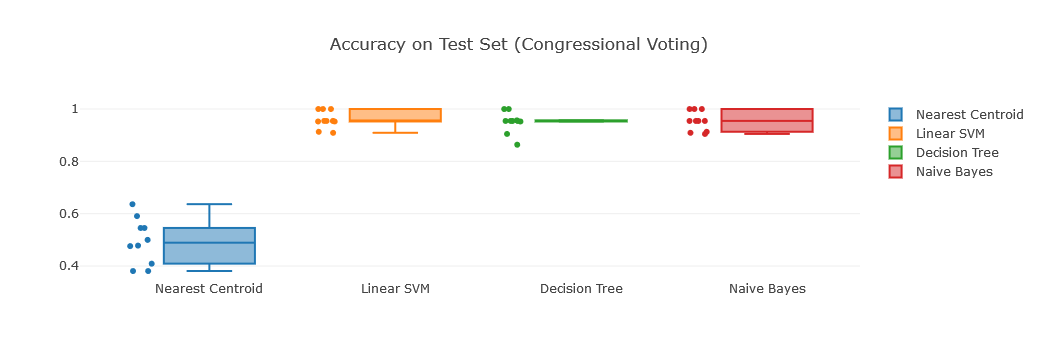

In [5]:
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_score'],
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="Accuracy on Test Set (Congressional Voting)")
    
py.iplot(go.Figure(data=traces, layout=layout))

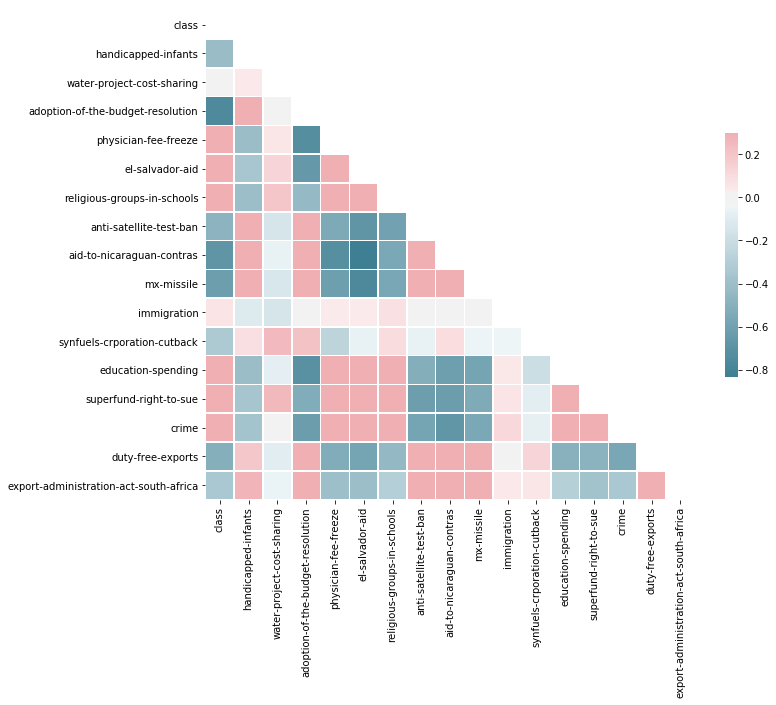

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
df_cor = df_train.replace({True:1, False:0})
df_cor['class'] = np.where(df_cor['class']=='republican',1.0,0.0)
df_cor = df_cor.drop('ID', axis=1)
corr = df_cor.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [22]:
df_cor

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,134,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,224,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,32,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
3,171,1,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN
4,333,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
5,148,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,83,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
7,24,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,281,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9,416,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
import sklearn
sklearn.__version__

'0.20.0'